https://x.com/nicorioscenteno/status/1621655101164118017

https://www.omnicalculator.com/physics/newtons-law-of-cooling

https://www.numberanalytics.com/blog/newtons-law-of-cooling-ultimate-guide#:~:text=Newton's%20Law%20of%20Cooling%20is,the%20body%20and%20its%20environment.

Agenda:

- Modelo para una marca con beta0 fijo
- Modelo para una marca con beta0 variable
- Modelo para todas las marcas con beta0 variable
- Modelo para todas las marcas con parametros jerarquicos (¿tambien para beta0?)

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import preliz as pz
import pymc as pm

In [2]:
random_seed = sum(map(ord, "comparacion de termos"))

## Ley de enfriamiento

$$
\frac{dT(t)}{dt} = r (T_\text{ambiente} - T(t))
$$

Una función que satisface la ecuacion es:

$$
T(t) = T_\text{ambiente} + (T_\text{inicial} - T_\text{ambiente}) e^{-rt}
$$

El logaritmo de la diferencia entre la temperatura en un tiempo $t$ y la temperatura ambiente es una función lineal:

$$
\begin{aligned}
T(t) - T_\text{ambiente} &= (T_\text{inicial} - T_\text{ambiente}) e^{-rt} \\
\log\left(T(t) - T_\text{ambiente}\right) &= \log\left((T_\text{inicial} - T_\text{ambiente}) e^{-rt}\right) \\
&= \log\left(T_\text{inicial} - T_\text{ambiente}\right) - rt \\
&= \alpha - \beta t
\end{aligned}
$$


donde:

* $\alpha = \log\left(T_\text{inicial} - T_\text{ambiente}\right)$
* $\beta = r$

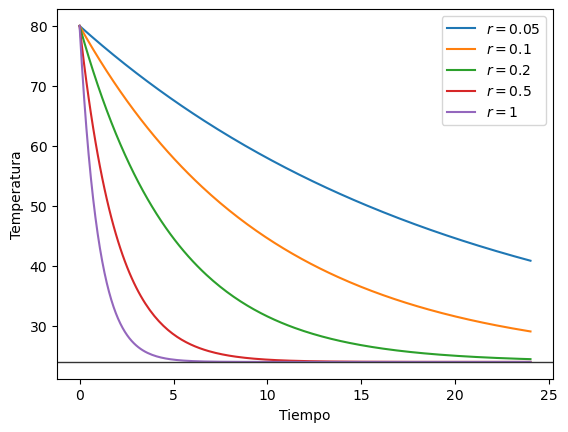

In [3]:
def calcular_temperatura(t, T_ambiente, T_inicial, r):
    return T_ambiente + (T_inicial - T_ambiente) * np.exp(-r * t)

T_inicial, T_ambiente = 80, 24
t_grid = np.linspace(0, 24, num=200)

fig, ax = plt.subplots()
ax.plot(t_grid, calcular_temperatura(t_grid, T_ambiente, T_inicial, 0.05), label="$r=0.05$");
ax.plot(t_grid, calcular_temperatura(t_grid, T_ambiente, T_inicial, 0.1), label="$r=0.1$");
ax.plot(t_grid, calcular_temperatura(t_grid, T_ambiente, T_inicial, 0.2), label="$r=0.2$");
ax.plot(t_grid, calcular_temperatura(t_grid, T_ambiente, T_inicial, 0.5), label="$r=0.5$");
ax.plot(t_grid, calcular_temperatura(t_grid, T_ambiente, T_inicial, 1), label="$r=1$");
ax.axhline(y=T_ambiente, color="0.2", lw=1)
ax.legend()
ax.set(xlabel="Tiempo", ylabel="Temperatura");

## Datos

In [4]:
temperatura_ambiente = 24
tiempo = np.array([0, 180, 320, 500]) / 60

datos = {
    "stanley": np.array([80.0, 70.0, 65.0, 60.0]),
    "aluminio": np.array([80.0, 62.5, 57.5, 50.0]),
    "lumilagro": np.array([75.0, 65.0, 60.0, 55.0]),
    "rosa": np.array([80.0, 47.5, 37.5, 30.0])
}

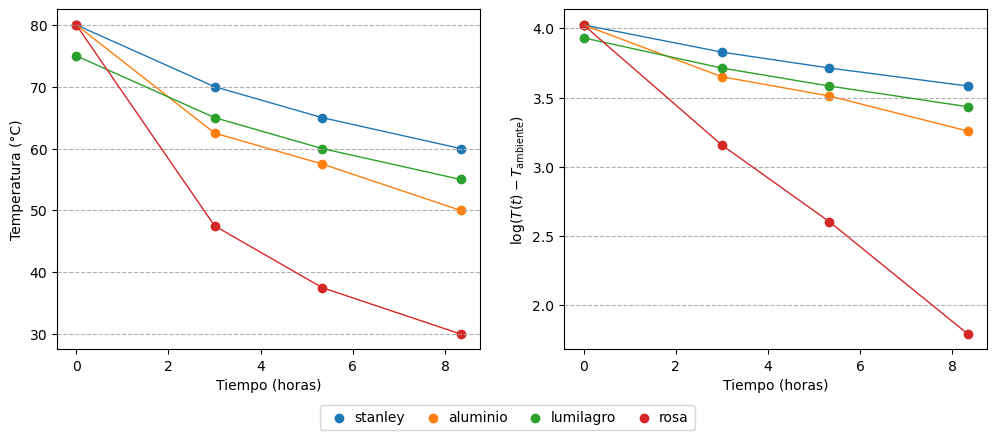

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.subplots_adjust(bottom=0.2)

for i, (marca, temperaturas) in enumerate(datos.items()):
    axes[0].plot(tiempo, temperaturas, color=f"C{i}", lw=1)
    axes[1].plot(tiempo, np.log(temperaturas - temperatura_ambiente), color=f"C{i}", lw=1)
    axes[0].scatter(tiempo, temperaturas, color=f"C{i}", label=marca)
    axes[1].scatter(tiempo, np.log(temperaturas - temperatura_ambiente), color=f"C{i}", label=marca)

axes[0].set(xlabel="Tiempo (horas)", ylabel="Temperatura (°C)");
axes[1].set(xlabel="Tiempo (horas)", ylabel="$\\log(T(t) - T_\\text{ambiente})$");
axes[0].grid(axis="y", which="major", zorder=-99, ls="--")
axes[1].grid(axis="y", which="major", zorder=-99, ls="--")

axes[1].legend(
    loc="lower center",
    ncol=4,
    bbox_to_anchor=(0.5, 0.025),
    bbox_transform=fig.transFigure,
    handletextpad=0.1,
    columnspacing=1
);

## Modelización

### Prior para $\sigma$

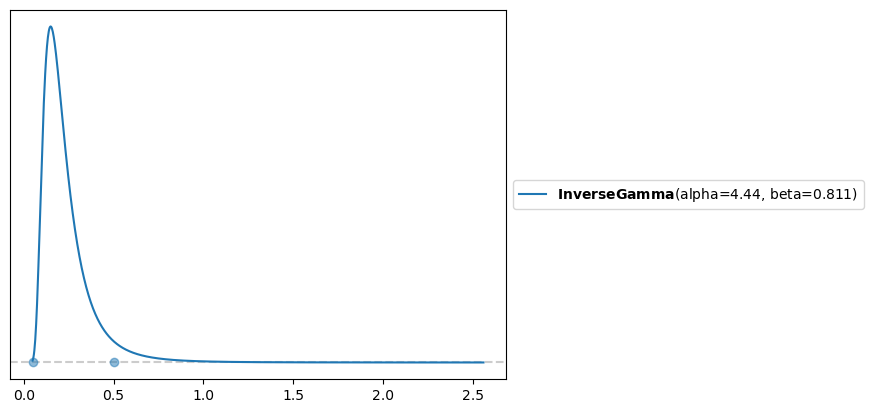

In [6]:
pz.maxent(pz.InverseGamma(), lower=0.05, upper=0.5, mass=0.95);

### Modelo 1: Intercepto conocido

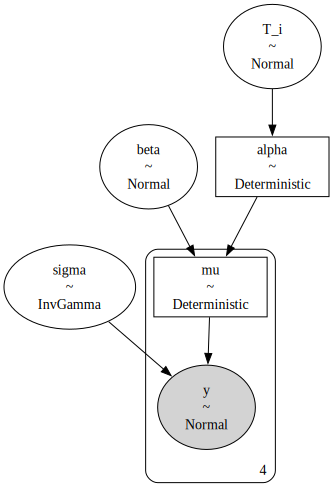

In [40]:
y_stanley = np.log(datos["stanley"] - temperatura_ambiente)

with pm.Model() as model_1:
    temperatura_inicial = 80
    temperatura_inicial = pm.Normal("T_i", mu=80, sigma=5)

    alpha = pm.Deterministic("alpha", np.log(temperatura_inicial - temperatura_ambiente))
    beta = pm.Normal("beta", mu=0, sigma=0.1)

    mu = pm.Deterministic("mu", alpha - beta * tiempo)
    sigma = pm.InverseGamma("sigma", alpha=4.5, beta=0.8)

    pm.Normal("y", mu=mu, sigma=sigma, observed=y_stanley)

model_1.to_graphviz()

In [42]:
with model_1:
    idata_1 = pm.sample(random_seed=random_seed, target_accept=0.99)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [T_i, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [44]:
az.summary(idata_1, var_names=["alpha", "beta", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,4.013,0.068,3.877,4.137,0.002,0.001,1334.0,1582.0,1.0
beta,0.052,0.017,0.018,0.082,0.000,0.001,1293.0,1394.0,1.0
sigma,0.133,0.056,0.051,0.229,0.002,0.002,1423.0,1978.0,1.0


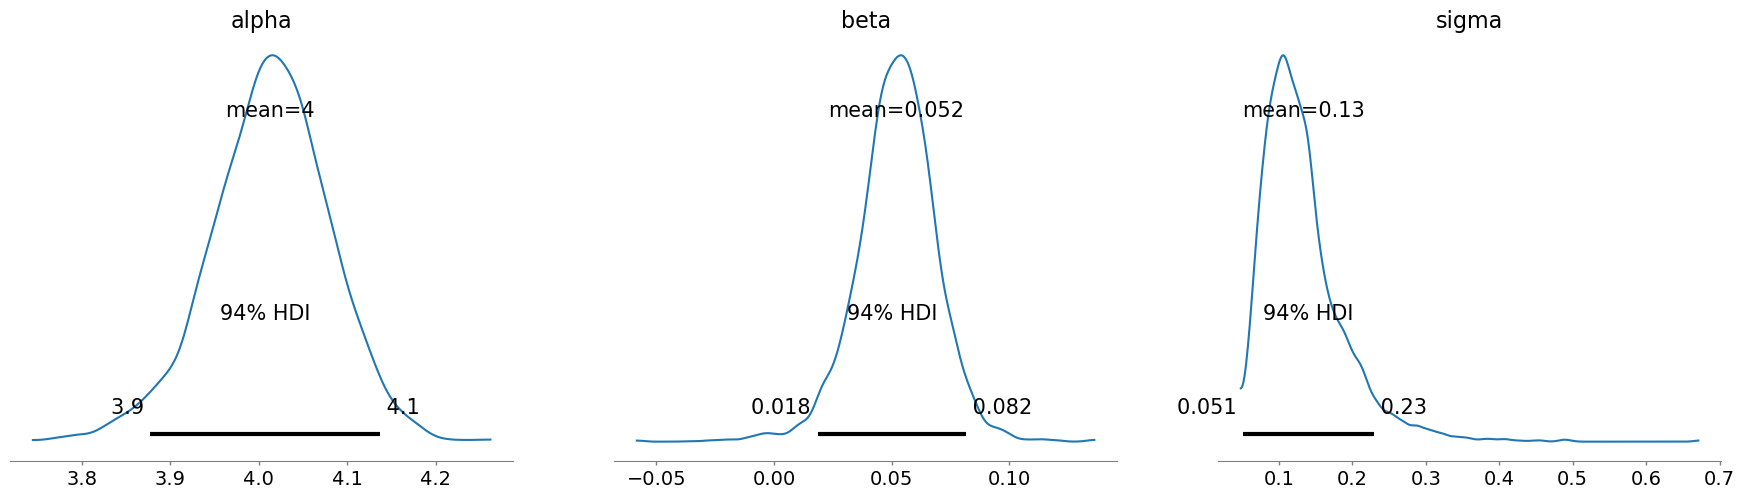

In [46]:
az.plot_posterior(idata_1, var_names=["alpha", "beta", "sigma"]);

In [48]:
# fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# t_grid = np.linspace(0, 9, num=100)
# alpha = np.log(temperatura_inicial - temperatura_ambiente)
# betas = idata_1.posterior["beta"].values.flatten()[::50]

# for beta in betas:
#     mu = alpha - beta * t_grid
#     axes[0].plot(t_grid, np.exp(mu) + temperatura_ambiente, color="0.5", lw=0.3)
#     axes[1].plot(t_grid, mu, color="0.5", lw=0.2)

# axes[0].scatter(tiempo, datos["stanley"]);
# axes[1].scatter(tiempo, y_stanley);

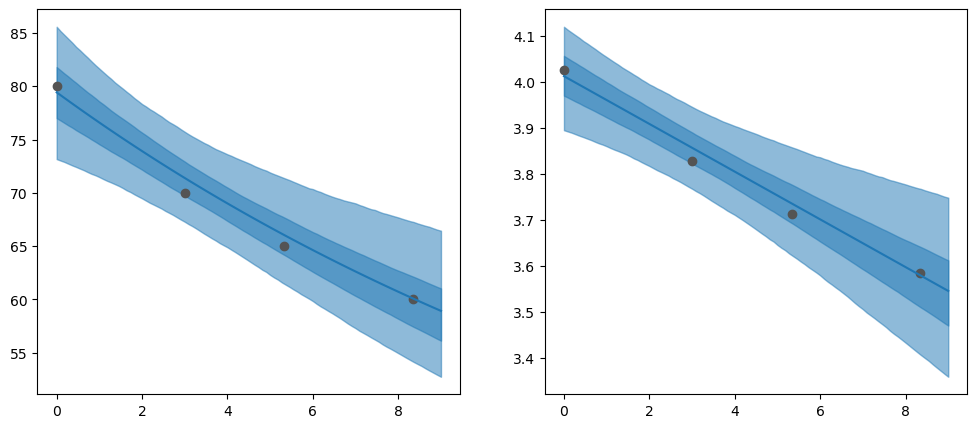

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

t_grid = np.linspace(0, 9, num=100)
alpha = np.log(temperatura_inicial - temperatura_ambiente)
alphas = idata_1.posterior["alpha"].values.flatten()
betas = idata_1.posterior["beta"].values.flatten()

mu_draws = (alphas[:, None] - betas[:, None] * t_grid)
mu_y_draws = np.exp(mu_draws) + temperatura_ambiente

mu_mean = mu_draws.mean(0)
mu_ci50 = np.quantile(mu_draws, q=(0.25, 0.75), axis=0)
mu_ci90 = np.quantile(mu_draws, q=(0.05, 0.95), axis=0)


mu_y_draws = np.exp(mu_draws) + temperatura_ambiente
mu_y_mean = mu_y_draws.mean(0)
mu_y_ci50 = np.quantile(mu_y_draws, q=(0.25, 0.75), axis=0)
mu_y_ci90 = np.quantile(mu_y_draws, q=(0.05, 0.95), axis=0)

axes[0].plot(t_grid, mu_y_mean)
axes[0].fill_between(x=t_grid, y1=mu_y_ci50[0], y2=mu_y_ci50[1], alpha=0.5, color="C0")
axes[0].fill_between(x=t_grid, y1=mu_y_ci90[0], y2=mu_y_ci90[1], alpha=0.5, color="C0")

axes[1].plot(t_grid, mu_mean)
axes[1].fill_between(x=t_grid, y1=mu_ci50[0], y2=mu_ci50[1], alpha=0.5, color="C0")
axes[1].fill_between(x=t_grid, y1=mu_ci90[0], y2=mu_ci90[1], alpha=0.5, color="C0")

axes[0].scatter(tiempo, datos["stanley"], color="0.33");
axes[1].scatter(tiempo, y_stanley, color="0.33");

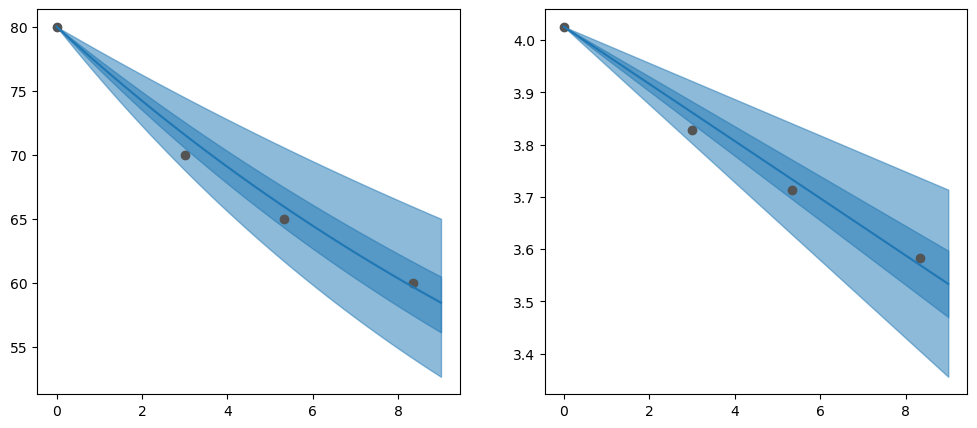

### Modelo 2: Intercepto desconocido

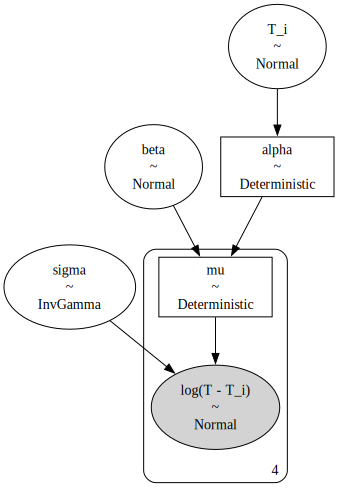

In [12]:
y_stanley = np.log(datos["stanley"] - temperatura_ambiente)

with pm.Model() as model_2:
    temperatura_inicial = pm.Normal("T_i", mu=80, sigma=0.5)
    alpha = pm.Deterministic("alpha", np.log(temperatura_inicial - temperatura_ambiente))
    beta = pm.Normal("beta", mu=0, sigma=0.1)

    mu = pm.Deterministic("mu", alpha - beta * tiempo)
    sigma = pm.InverseGamma("sigma", alpha=4.5, beta=0.8)

    pm.Normal("log(T - T_i)", mu=mu, sigma=sigma, observed=y_stanley)

model_2.to_graphviz()

In [13]:
with model_2:
    idata_2 = pm.sample(random_seed=random_seed)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [T_i, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [14]:
az.summary(idata_2, var_names=["alpha", "beta", "sigma", "T_i"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,4.025,0.009,4.009,4.042,0.000,0.000,2542.0,2380.0,1.0
beta,0.055,0.013,0.031,0.079,0.000,0.000,2254.0,1828.0,1.0
sigma,0.125,0.053,0.049,0.213,0.001,0.002,2045.0,1996.0,1.0
T_i,79.999,0.495,79.113,80.932,0.010,0.008,2542.0,2380.0,1.0


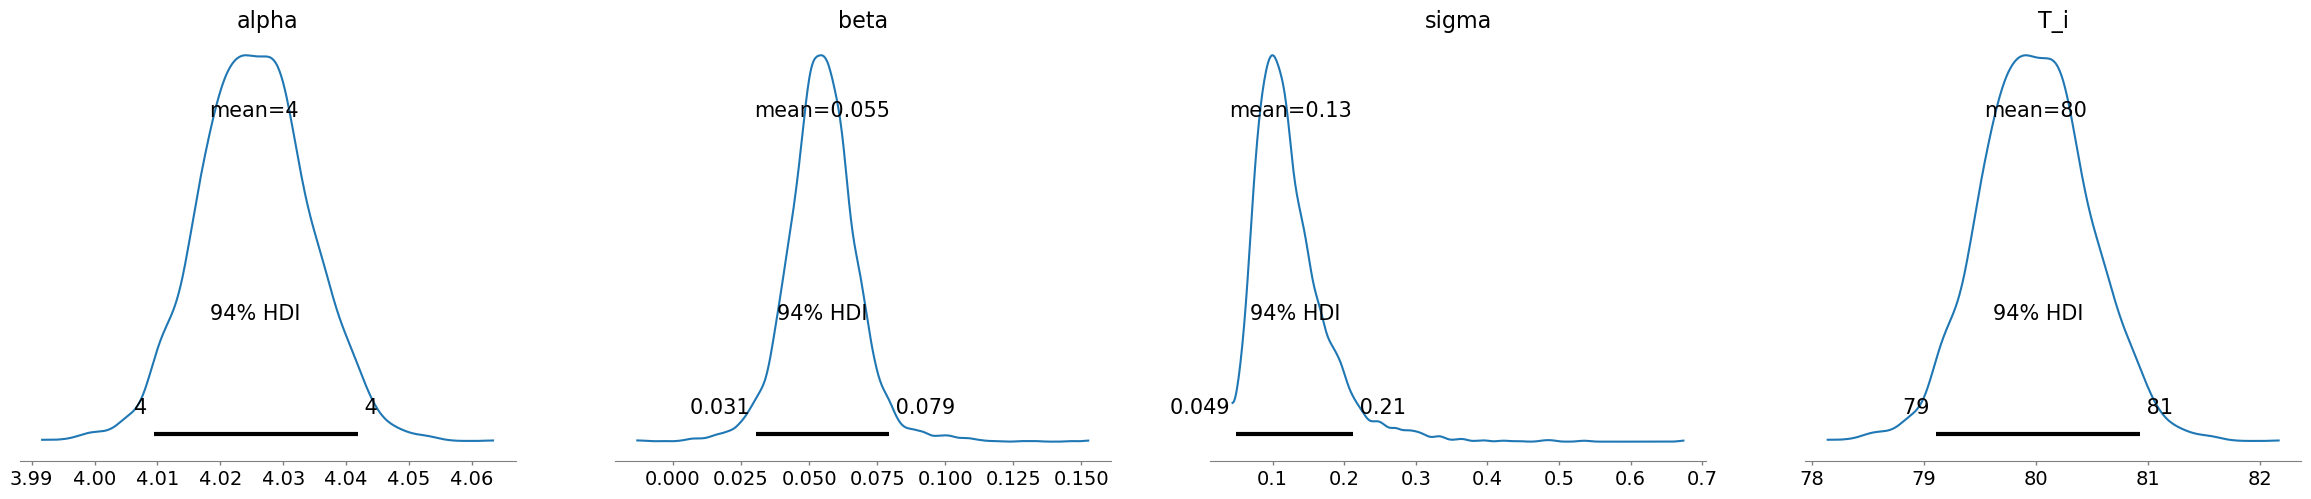

In [15]:
az.plot_posterior(idata_2, var_names=["alpha", "beta", "sigma", "T_i"]);

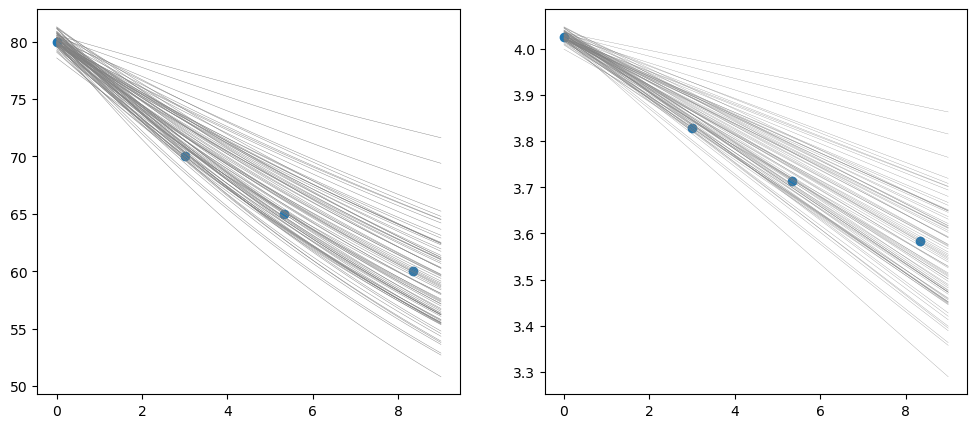

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

t_grid = np.linspace(0, 9, num=100)
alpha = np.log(temperatura_inicial - temperatura_ambiente)
betas = idata_2.posterior["beta"].values.flatten()[::50]
alphas = idata_2.posterior["alpha"].values.flatten()[::50]

for alpha, beta in zip(alphas, betas):
    mu = alpha - beta * t_grid
    axes[0].plot(t_grid, np.exp(mu) + temperatura_ambiente, color="0.5", lw=0.3)
    axes[1].plot(t_grid, mu, color="0.5", lw=0.2)

axes[0].scatter(tiempo, datos["stanley"]);
axes[1].scatter(tiempo, y_stanley);

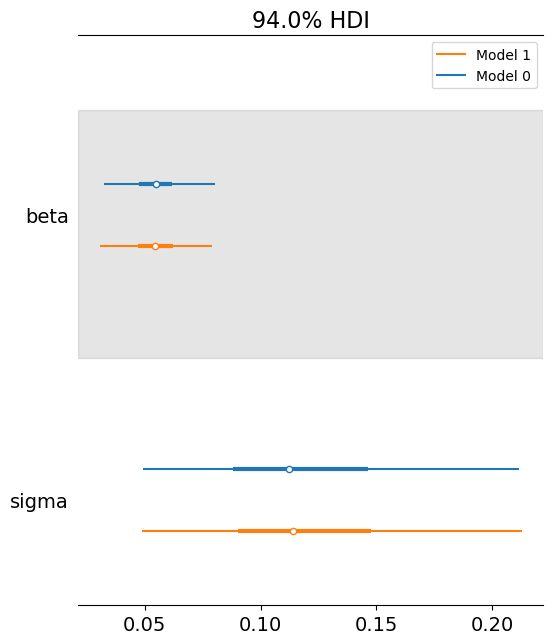

In [17]:
az.plot_forest([idata_1, idata_2], var_names=["beta", "sigma"], combined=True);

### Modelo multimarca

In [45]:
y = np.log(np.concatenate([temps for temps in datos.values()]) - temperatura_ambiente)
marca_idx = np.repeat(np.arange(4), 4)
tiempos = np.tile(tiempo, 4)

marca_idx, tiempos

(array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]),
 array([0.        , 3.        , 5.33333333, 8.33333333, 0.        ,
        3.        , 5.33333333, 8.33333333, 0.        , 3.        ,
        5.33333333, 8.33333333, 0.        , 3.        , 5.33333333,
        8.33333333]))

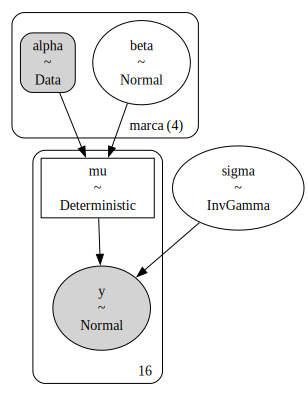

In [46]:
coords = {"marca": list(datos)}

with pm.Model(coords=coords) as model_3:
    temperatura_inicial = np.array([temps[0].item() for temps in datos.values()])
    alpha = pm.Data("alpha", np.log(temperatura_inicial - temperatura_ambiente), dims="marca")
    beta = pm.Normal("beta", mu=0, sigma=0.1, dims="marca")

    mu = pm.Deterministic("mu", alpha[marca_idx] - beta[marca_idx] * tiempos)
    sigma = pm.InverseGamma("sigma", alpha=4.5, beta=0.8)

    pm.Normal("y", mu=mu, sigma=sigma, observed=y)

model_3.to_graphviz()

In [47]:
with model_3:
    idata_3 = pm.sample_prior_predictive(draws=1000)
    idata_3.extend(pm.sample(random_seed=random_seed, target_accept=0.99))

Sampling: [beta, sigma, y]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


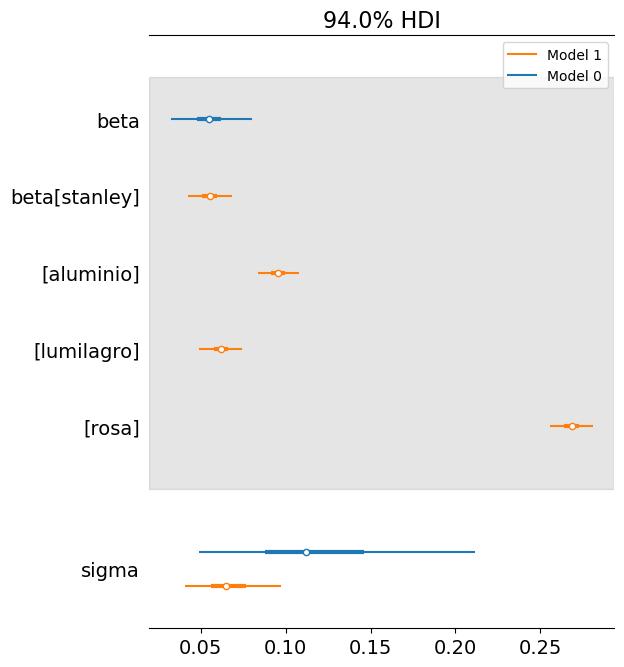

In [48]:
az.plot_forest([idata_1, idata_3], var_names=["beta", "sigma"], combined=True);

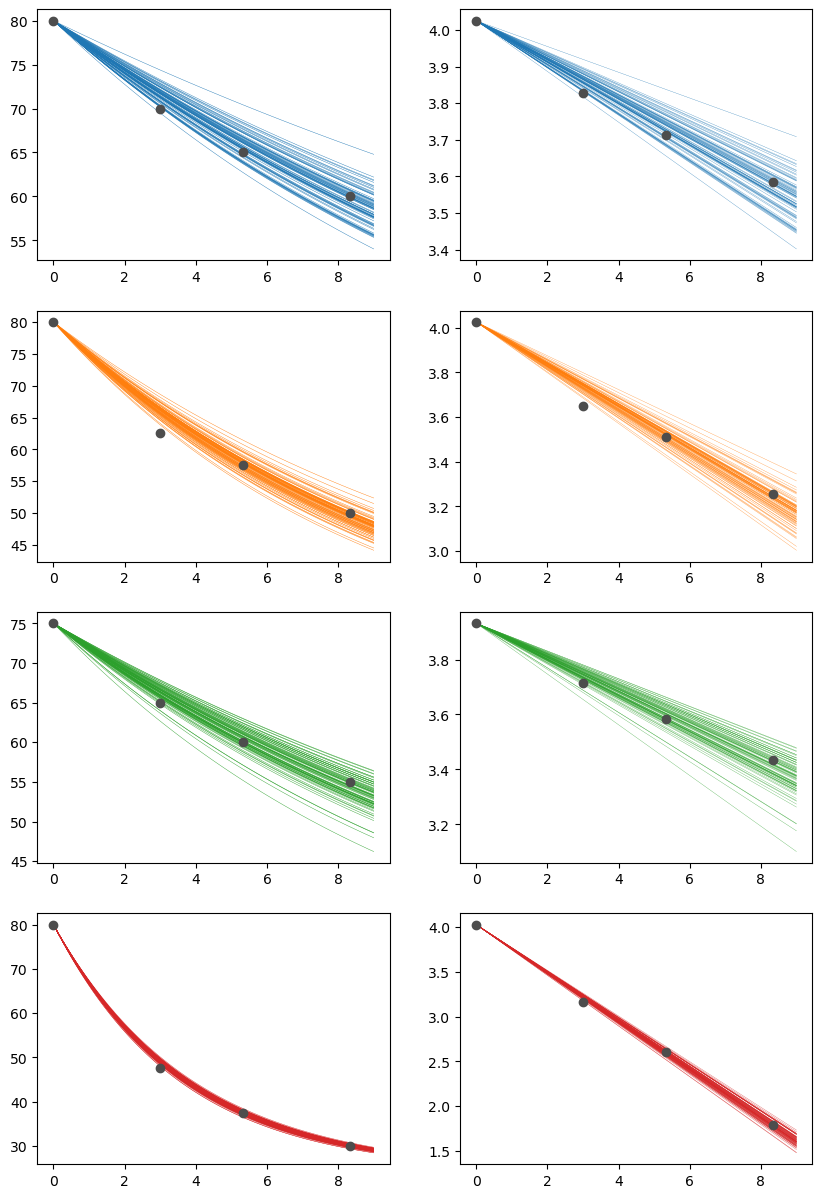

In [49]:
fig, axes = plt.subplots(4, 2, figsize=(10, 15))

t_grid = np.linspace(0, 9, num=100)
alpha = np.log(temperatura_inicial - temperatura_ambiente)

for i, marca in enumerate(datos):
    alpha = idata_3.constant_data.sel(marca=marca)["alpha"].item()
    betas = idata_3.posterior.sel(marca=marca)["beta"].values.flatten()[::50]

    for beta in betas:
        mu = alpha - beta * t_grid
        axes[i, 0].plot(t_grid, np.exp(mu) + temperatura_ambiente, color=f"C{i}", lw=0.3)
        axes[i, 1].plot(t_grid, mu, color=f"C{i}", lw=0.2)

    axes[i, 0].scatter(tiempo, datos[marca], color="0.3", zorder=10);
    axes[i, 1].scatter(tiempo, np.log(datos[marca] - temperatura_ambiente), color="0.3", zorder=10);

### Modelo multimarca jerárquico

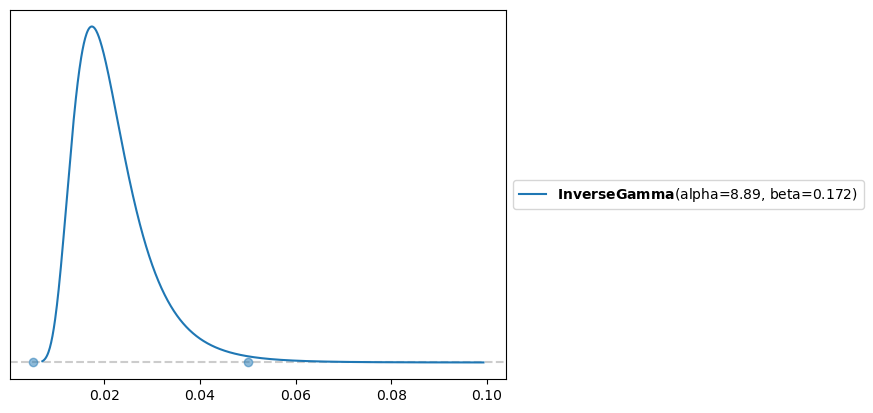

In [258]:
pz.maxent(pz.InverseGamma(), lower=0.005, upper=0.05, mass=0.99);

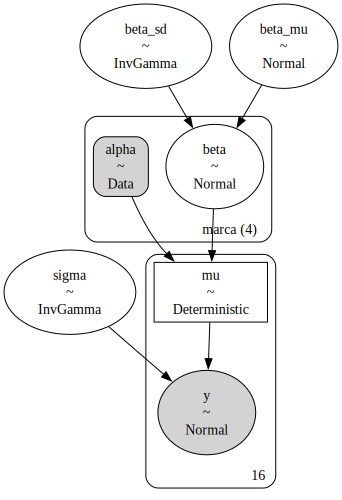

In [50]:
coords = {"marca": list(datos)}

with pm.Model(coords=coords) as model_4:
    temperatura_inicial = np.array([temps[0].item() for temps in datos.values()])
    alpha = pm.Data("alpha", np.log(temperatura_inicial - temperatura_ambiente), dims="marca")

    beta_mu = pm.Normal("beta_mu", mu=0.15, sigma=0.01)
    beta_sd = pm.InverseGamma("beta_sd", alpha=9, beta=0.17)

    beta = pm.Normal("beta", mu=beta_mu, sigma=beta_sd, dims="marca")

    mu = pm.Deterministic("mu", alpha[marca_idx] - beta[marca_idx] * tiempos)
    sigma = pm.InverseGamma("sigma", alpha=4.5, beta=0.8)

    pm.Normal("y", mu=mu, sigma=sigma, observed=y)

model_4.to_graphviz()

In [51]:
with model_4:
    idata_4 = pm.sample_prior_predictive(draws=1000)
    idata_4.extend(pm.sample(random_seed=random_seed, target_accept=0.99))

Sampling: [beta, beta_mu, beta_sd, sigma, y]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_mu, beta_sd, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


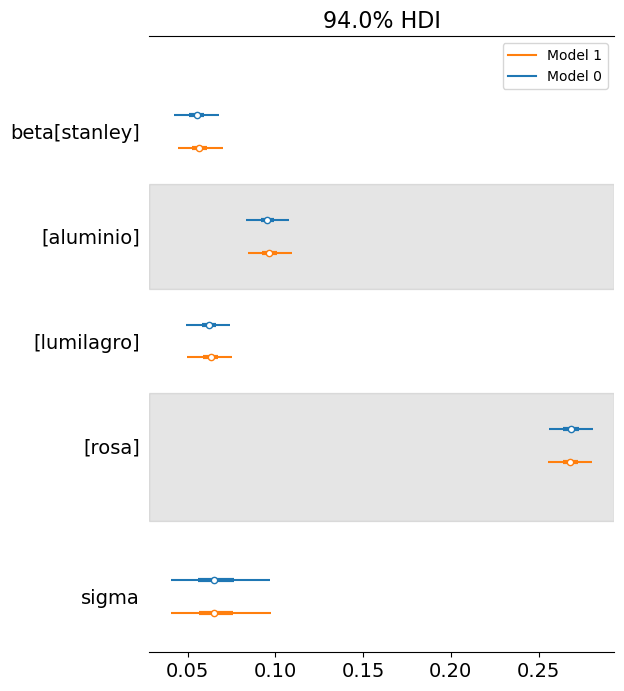

In [52]:
az.plot_forest([idata_3, idata_4], var_names=["beta", "sigma"], combined=True);

In [53]:
az.summary(idata_3, var_names=["beta", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[stanley],0.055,0.007,0.042,0.068,0.0,0.0,2862.0,2323.0,1.0
beta[aluminio],0.095,0.006,0.083,0.108,0.0,0.0,3507.0,2707.0,1.0
beta[lumilagro],0.062,0.007,0.049,0.074,0.0,0.0,2675.0,2138.0,1.0
beta[rosa],0.268,0.007,0.256,0.281,0.0,0.0,2896.0,2016.0,1.0
sigma,0.067,0.016,0.041,0.097,0.0,0.0,1776.0,2170.0,1.0


In [54]:
az.summary(idata_4, var_names=["beta_mu", "beta_sd", "beta", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_mu,0.147,0.009,0.130,0.165,0.0,0.0,4299.0,3020.0,1.0
beta_sd,0.061,0.014,0.038,0.088,0.0,0.0,4246.0,2458.0,1.0
beta[stanley],0.057,0.007,0.045,0.070,0.0,0.0,3573.0,2587.0,1.0
beta[aluminio],0.097,0.007,0.084,0.109,0.0,0.0,3587.0,3018.0,1.0
beta[lumilagro],0.063,0.007,0.050,0.075,0.0,0.0,3858.0,2665.0,1.0
beta[rosa],0.268,0.007,0.256,0.280,0.0,0.0,3634.0,2590.0,1.0
sigma,0.068,0.017,0.040,0.097,0.0,0.0,2440.0,2366.0,1.0


### Model multimarca inicio desconocido

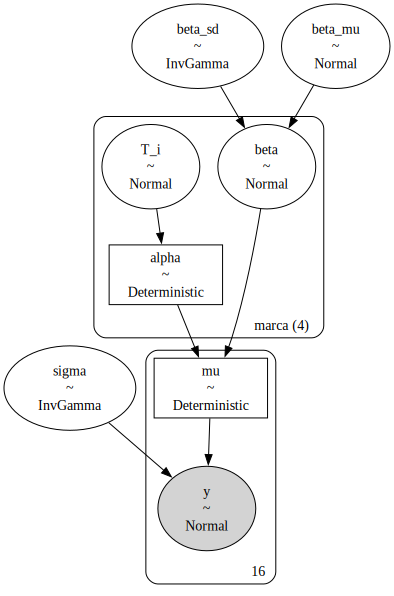

In [60]:
coords = {"marca": list(datos)}

with pm.Model(coords=coords) as model_5:
    temperatura_inicial = np.array([temps[0].item() for temps in datos.values()])
    temperatura_inicial = pm.Normal("T_i", mu=temperatura_inicial, sigma=5, dims="marca")
    alpha = pm.Deterministic("alpha", np.log(temperatura_inicial - temperatura_ambiente), dims="marca")


    beta_mu = pm.Normal("beta_mu", mu=0.15, sigma=0.01)
    beta_sd = pm.InverseGamma("beta_sd", alpha=9, beta=0.17)

    beta = pm.Normal("beta", mu=beta_mu, sigma=beta_sd, dims="marca")

    mu = pm.Deterministic("mu", alpha[marca_idx] - beta[marca_idx] * tiempos)
    sigma = pm.InverseGamma("sigma", alpha=4.5, beta=0.8)

    pm.Normal("y", mu=mu, sigma=sigma, observed=y)

model_5.to_graphviz()

In [61]:
with model_5:
    idata_5 = pm.sample_prior_predictive(draws=1000)
    idata_5.extend(pm.sample(random_seed=random_seed, target_accept=0.99))

Sampling: [T_i, beta, beta_mu, beta_sd, sigma, y]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [T_i, beta_mu, beta_sd, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


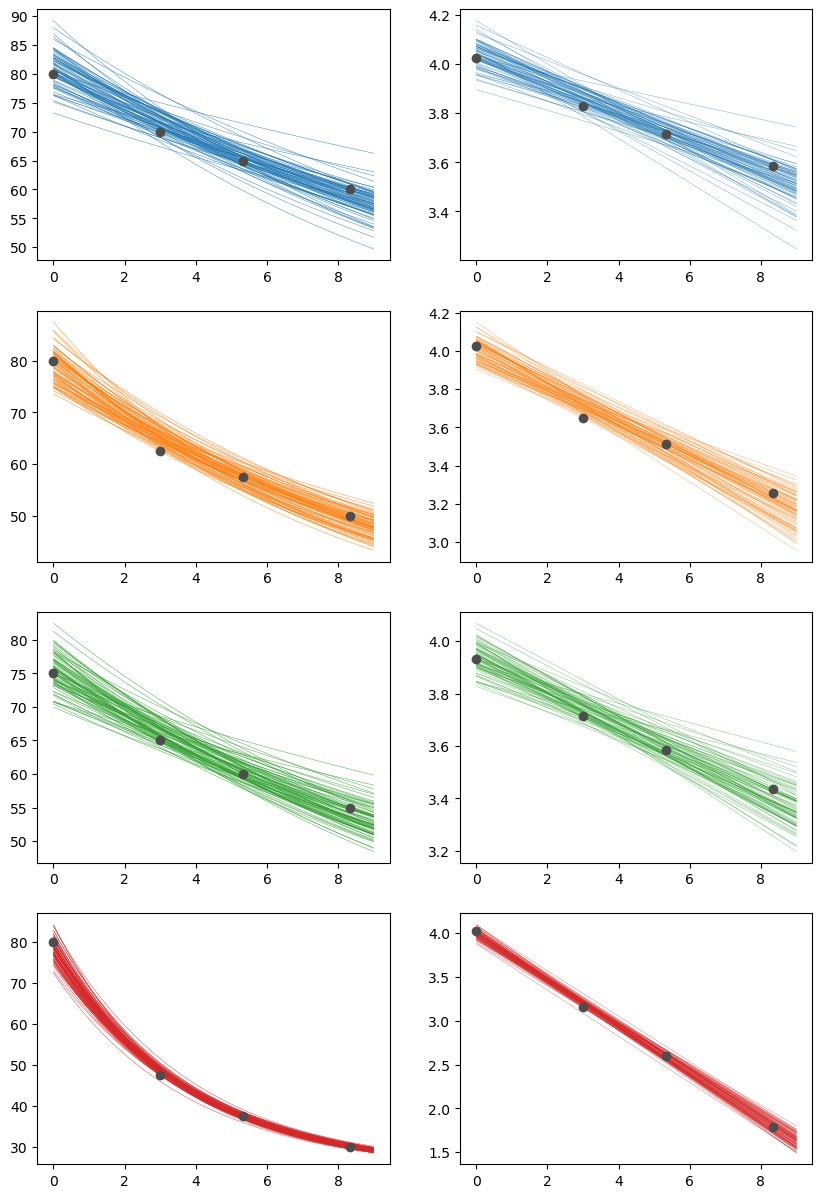

In [62]:
fig, axes = plt.subplots(4, 2, figsize=(10, 15))

t_grid = np.linspace(0, 9, num=100)
alpha = np.log(temperatura_inicial - temperatura_ambiente)

for i, marca in enumerate(datos):
    alphas = idata_5.posterior.sel(marca=marca)["alpha"].values.flatten()[::50]
    betas = idata_5.posterior.sel(marca=marca)["beta"].values.flatten()[::50]

    for alpha, beta in zip(alphas, betas):
        mu = alpha - beta * t_grid
        axes[i, 0].plot(t_grid, np.exp(mu) + temperatura_ambiente, color=f"C{i}", lw=0.3)
        axes[i, 1].plot(t_grid, mu, color=f"C{i}", lw=0.2)

    axes[i, 0].scatter(tiempo, datos[marca], color="0.3", zorder=10);
    axes[i, 1].scatter(tiempo, np.log(datos[marca] - temperatura_ambiente), color="0.3", zorder=10);

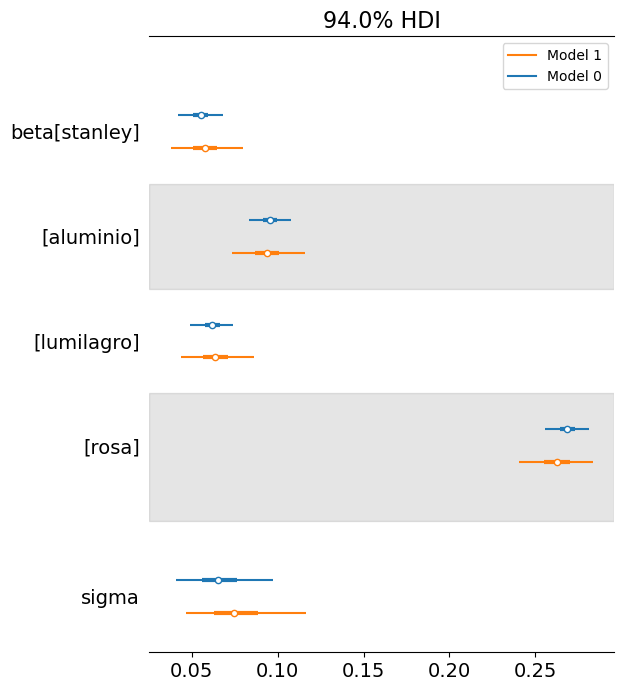

In [63]:
az.plot_forest([idata_3, idata_5], var_names=["beta", "sigma"], combined=True);

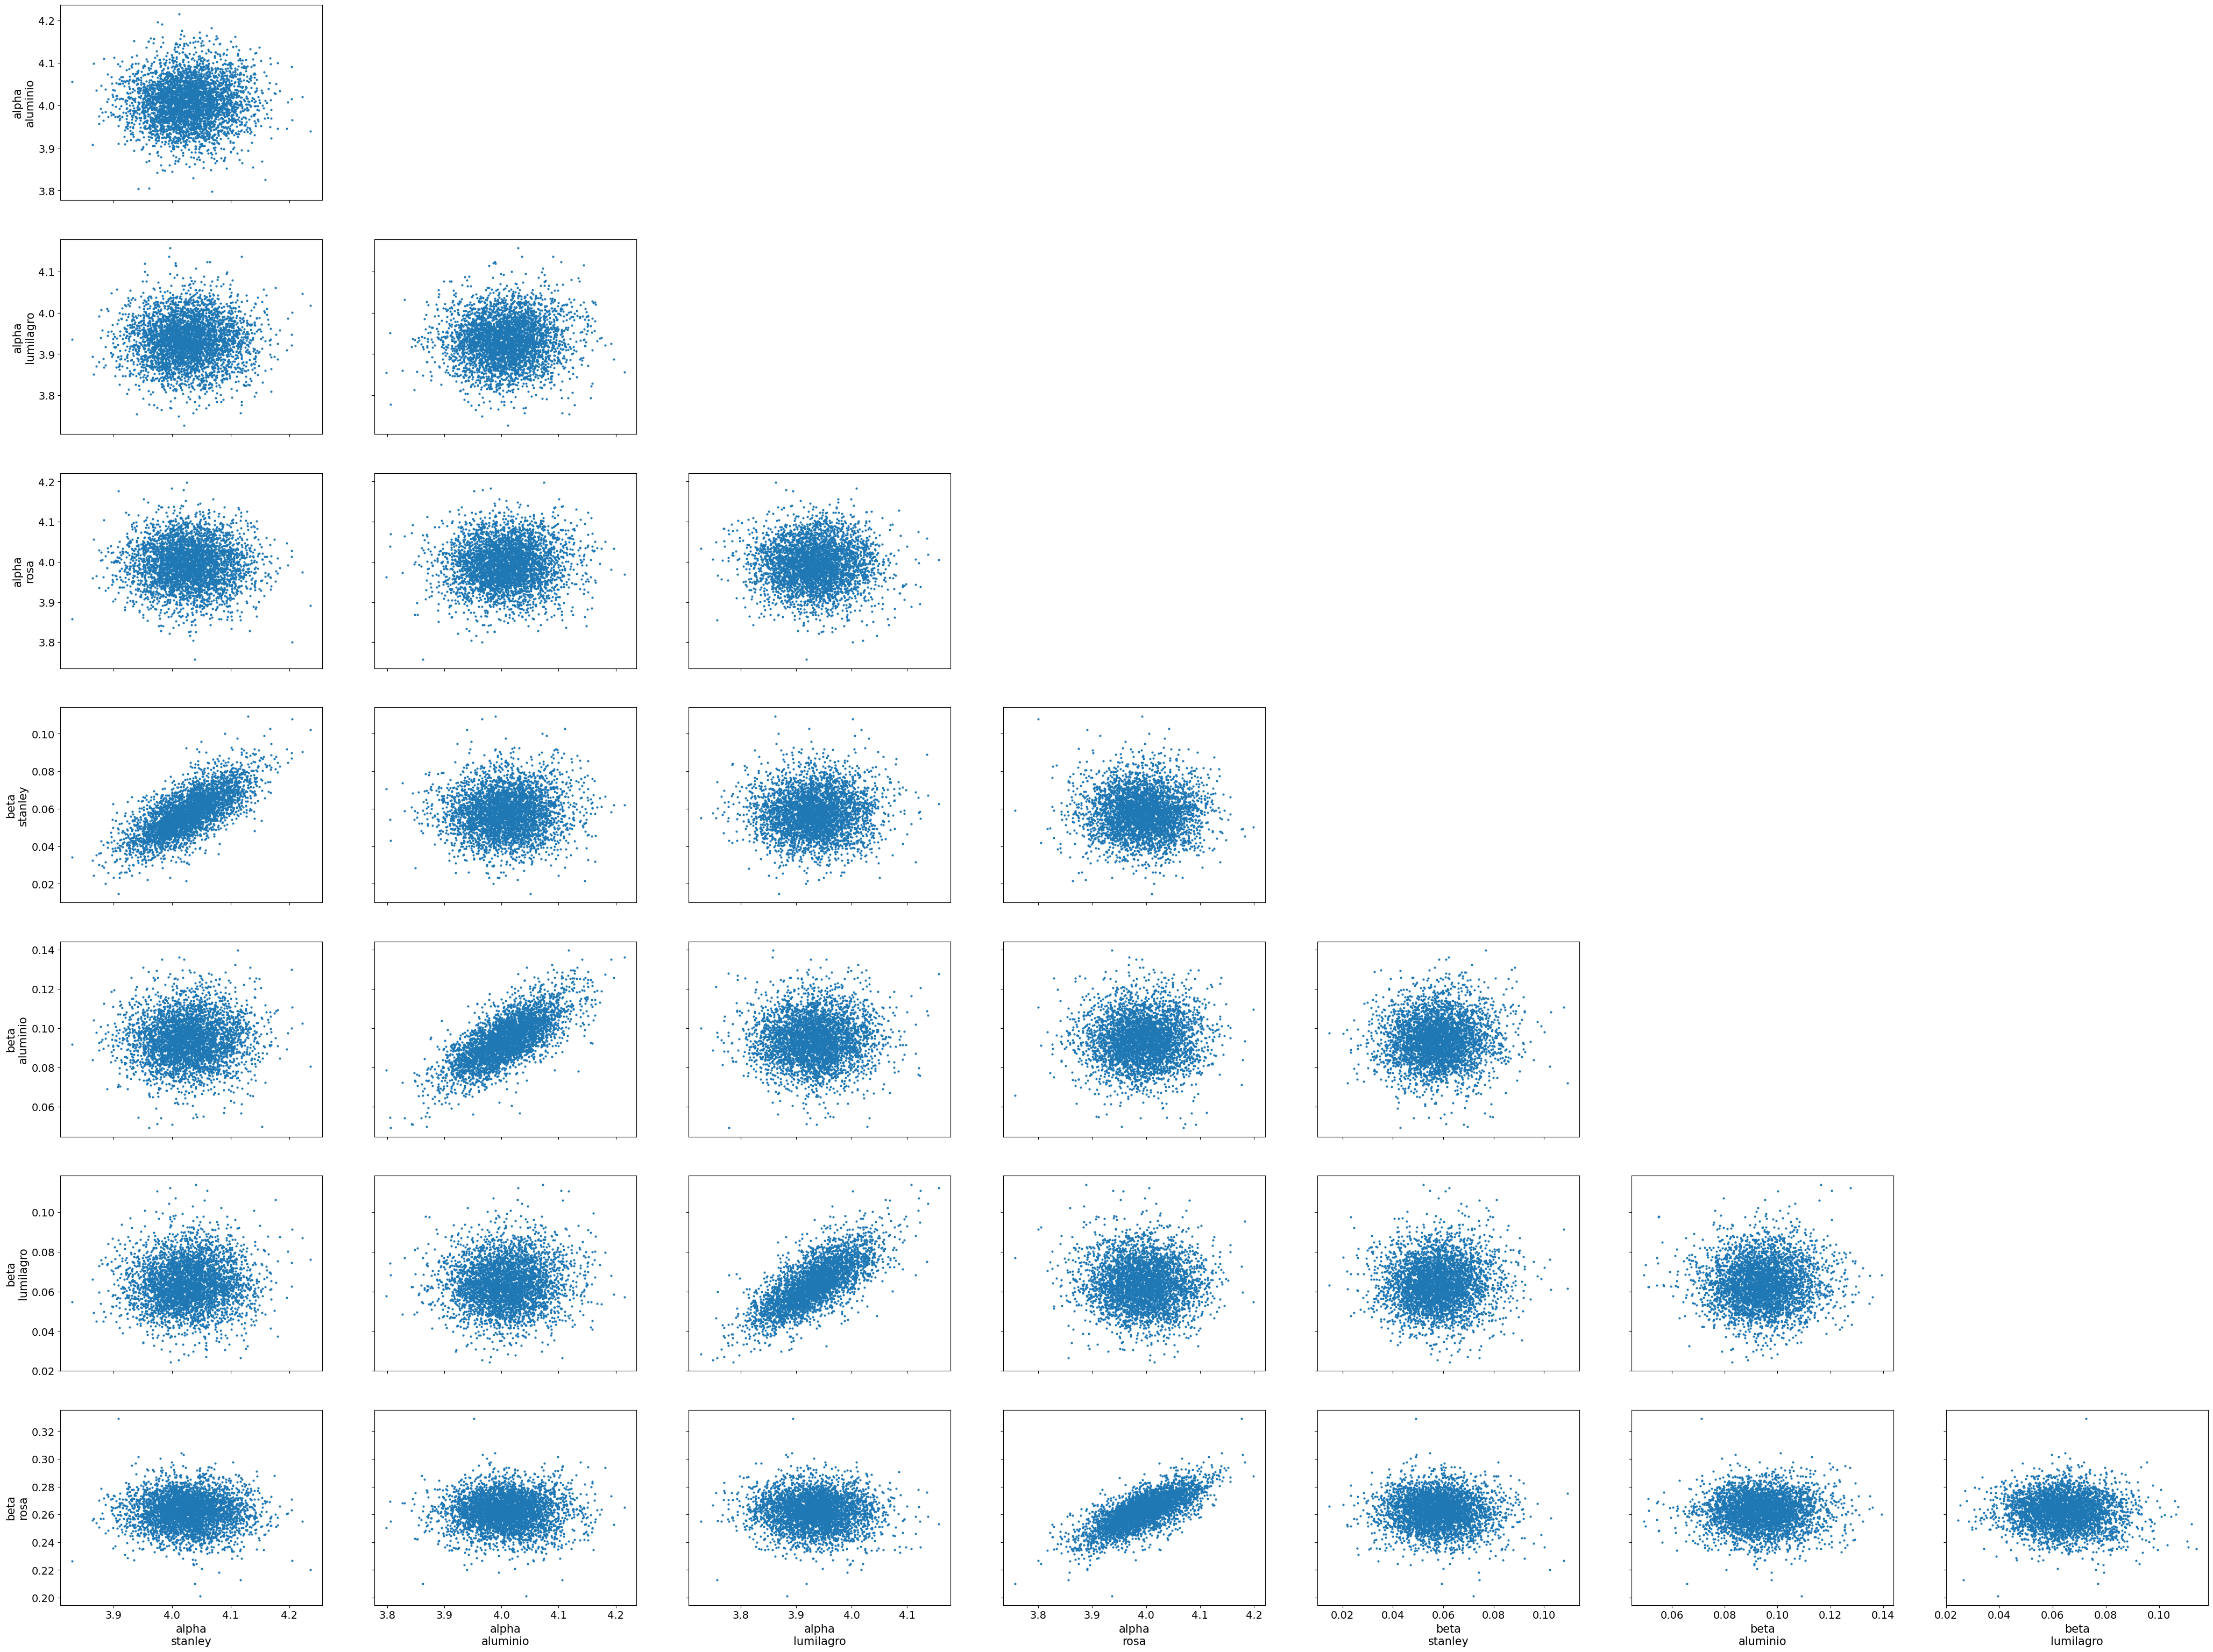

In [65]:
az.plot_pair(idata_5, var_names=["alpha", "beta"]);

To Do:

- Elucidación de prior para la pendiente.